In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import ChebConv
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import ttest_ind
import networkx as nx
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [23]:
dataset = torch.load('nfl_coaches_subset.pt', weights_only=False)

In [24]:
feature_names = ['Yrs', 'G', 'W', 'T', 'W-L%', 'G > .500', 'AvRk', 'BstRk', 'HOF']
# Add boolean feature for winning record
winning_record = (dataset.x[:, 4] > 0.425).float()  # W-L% is at index 4
dataset.y = winning_record

# Update feature names
feature_names.append('Winning Record')


In [25]:
dataset.y.sum()/dataset.y.shape[0]

tensor(0.5143)

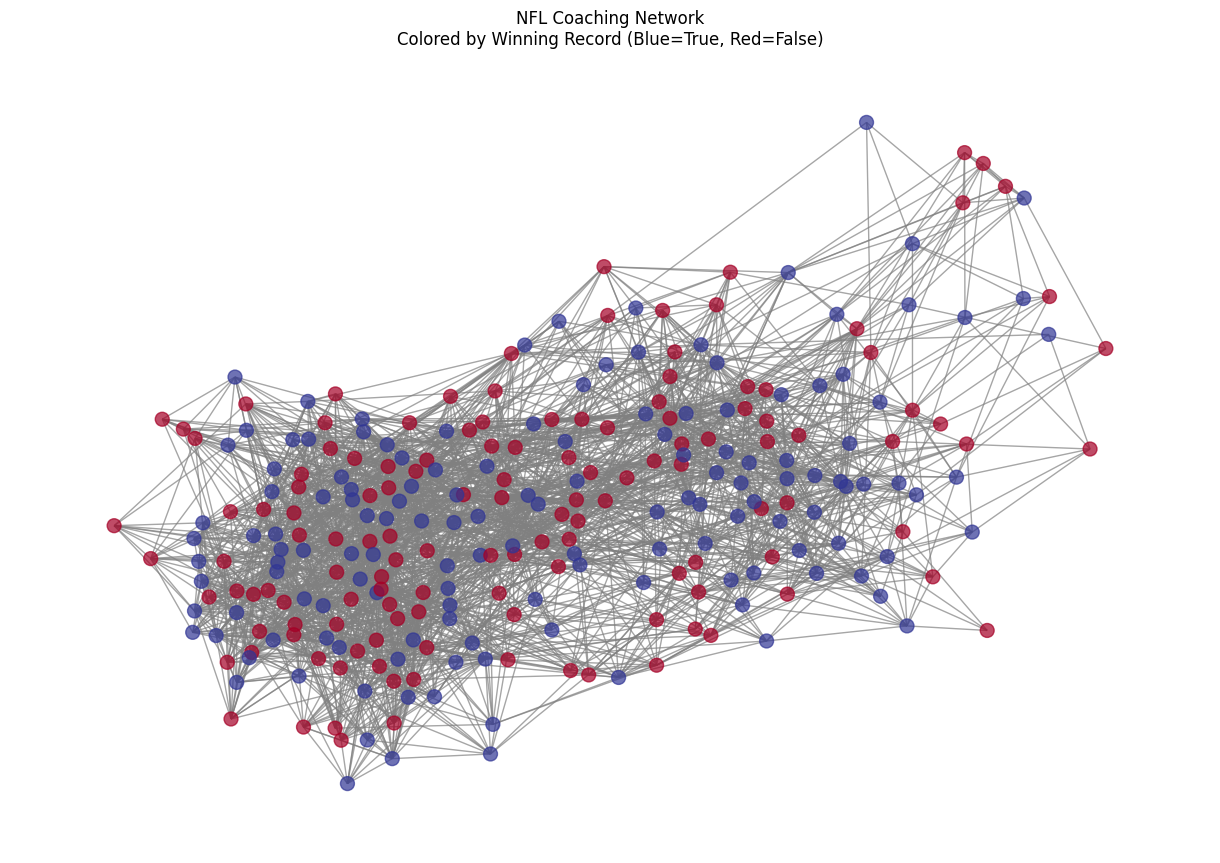

In [26]:
G = nx.Graph()
edge_index = dataset.edge_index.numpy()
for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0,i], edge_index[1,i])

pos = nx.spring_layout(G)

plt.figure(figsize=(12,8))

node_colors = dataset.y.numpy()
nx.draw(G, pos, node_color=node_colors, node_size=100, cmap=plt.cm.RdYlBu,
        with_labels=False, edge_color='gray', alpha=0.7)

plt.title("NFL Coaching Network\nColored by Winning Record (Blue=True, Red=False)")
plt.show()


In [27]:
def train_test_split(dataset, train_ratio=0.5, seed=42):
    torch.manual_seed(seed)
    mask = torch.rand(dataset.x.shape[0]) < train_ratio
    train_mask = mask
    test_mask = ~mask
    train_dataset = dataset.subgraph(train_mask)
    test_dataset = dataset.subgraph(test_mask)
    return train_dataset, test_dataset

train_dataset, test_dataset = train_test_split(dataset)

In [28]:
class ChebGNN(nn.Module):
    def __init__(self, in_channels, K=3):
        super().__init__()
        self.conv1 = ChebConv(in_channels, 32, K=K)
        self.conv2 = ChebConv(32, 16, K=K)
        self.lin = nn.Linear(16, 2)  # Output 2 classes
        
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        out = self.lin(x)
        return F.log_softmax(out, dim=1)  # Apply softmax for classification
    
class GCN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = torch.nn.Linear(in_channels, 32)
        self.conv2 = torch.nn.Linear(32, 16)
        self.lin = nn.Linear(16, 2)  # Output 2 classes
        
    def forward(self, x, edge_index):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        out = self.lin(x)
        return F.log_softmax(out, dim=1)  # Apply softmax for classification
    
def run_experiment(train_dataset, test_dataset, model, feature_name='W-L%', plot=False, verbose=False):
    feature_names = ['Yrs', 'G', 'W', 'T', 'W-L%', 'G > .500', 'AvRk', 'BstRk', 'HOF']
    feature_idx = feature_names.index(feature_name)
    
    X_train = train_dataset.x.numpy()
    X_train = torch.tensor(X_train[:,feature_idx].reshape(-1,1))
    edge_index_train = train_dataset.edge_index

    X_test = test_dataset.x.numpy() 
    X_test = torch.tensor(X_test[:,feature_idx].reshape(-1,1))
    edge_index_test = test_dataset.edge_index

    y_train = train_dataset.y.long()  # Convert to long for classification
    y_test = test_dataset.y.long()

    criterion = nn.NLLLoss()  # Use negative log likelihood loss for classification
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

    train_losses = []

    for epoch in range(200):
        model.train()
        optimizer.zero_grad()
        out = model(X_train, edge_index_train)
        loss = criterion(out, y_train)
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())

    if plot:
        plt.figure(figsize=(10,6))
        plt.subplot(1,1,1)
        plt.plot(train_losses, label='Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Classification of {feature_name}')
        plt.legend()

    model.eval()
    with torch.no_grad():
        out = model(X_test, edge_index_test)
        y_pred = out.argmax(dim=1).numpy()
        y_true = y_test.numpy()
        
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        p_value = ttest_ind(y_true, y_pred, alternative='greater').pvalue
        
        if plot:
            plt.figure(figsize=(6,6))
            cm = confusion_matrix(y_true, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.show()
        
        if verbose:
            print(f"Test Set Evaluation for {feature_name}:")
            print(f"Accuracy: {accuracy:.4f}")
            print(f"F1 Score: {f1:.4f}")
            
            print("\nSample Predictions:")
            print("Actual\tPredicted")
            for actual, pred in zip(y_true[:5], y_pred[:5]):
                print(f"{actual}\t{pred}")

        return accuracy, f1, p_value


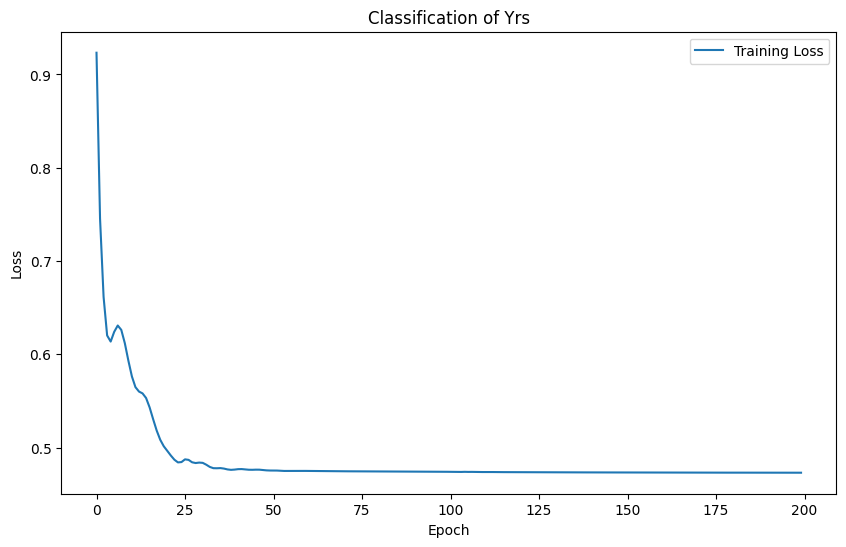

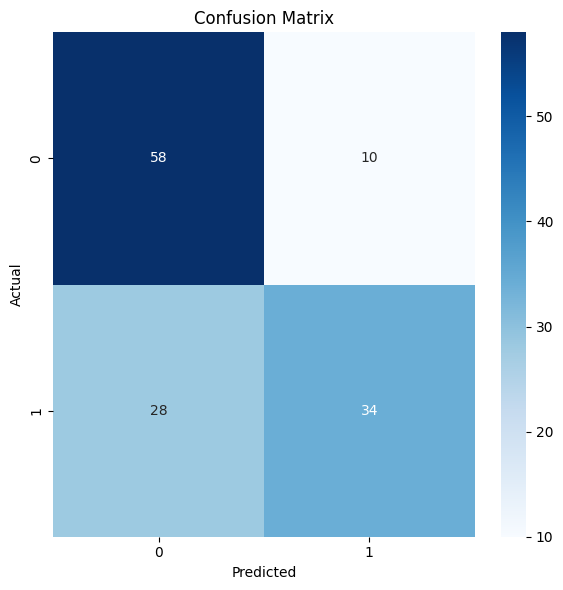

Test Set Evaluation for Yrs:
Accuracy: 0.7077
F1 Score: 0.6415

Sample Predictions:
Actual	Predicted
1	1
1	1
1	1
0	1
0	0


(0.7076923076923077, 0.6415094339622641, 0.011541101942259997)

In [29]:
model = GCN(1)

run_experiment(model = model, feature_name='Yrs', train_dataset=train_dataset, test_dataset=test_dataset, plot=True, verbose=True)

In [30]:
def edge_index_to_adj(edge_index, num_nodes):
    adj = torch.zeros((num_nodes, num_nodes))
    edge_index = edge_index.long()
    adj[edge_index[0], edge_index[1]] = 1
    adj = adj + adj.t()
    return adj


In [31]:
def assign_step(centers, embeddings):
    distances = torch.cdist(centers, embeddings)
    assignments = torch.argmin(distances, dim=0)
    return assignments

def update_step(embeddings, assignments):
    centers = torch.zeros((embeddings.shape[1], embeddings.shape[1]))
    for i in range(embeddings.shape[1]):
        centers[i] = torch.mean(embeddings[assignments == i], dim=0)

    return centers

In [32]:
def CMeans(adj, C):

    eigenvalues, eigenvectors = torch.linalg.eigh(adj)

    sorted_indices = torch.argsort(torch.abs(eigenvalues), descending=True)
    embeddings = eigenvectors[:, sorted_indices[:C]]
    
    # Initialize clusters
    node_choices = np.random.choice(embeddings.shape[0], size=C, replace=False)
    centers = embeddings[node_choices]

    assignments_old = torch.zeros(embeddings.shape[0])

    while True:
        assignments = assign_step(centers, embeddings)

        centers = update_step(embeddings, assignments)

        if torch.all(assignments == assignments_old):
            break

        assignments_old = assignments
    # Convert assignments to one-hot encoding
    one_hot = torch.zeros((embeddings.shape[0], C))
    one_hot[torch.arange(embeddings.shape[0]), assignments.long()] = 1
    assignments = one_hot
    return assignments, centers

In [33]:
def calculate_accuracy(true_assignments, pred_assignments):
    from scipy.optimize import linear_sum_assignment
    
    true_labels = true_assignments.argmax(dim=1)
    pred_labels = pred_assignments.argmax(dim=1)
    
    n_classes = true_assignments.shape[1]
    confusion = torch.zeros((n_classes, n_classes))
    for i in range(len(true_labels)):
        confusion[true_labels[i], pred_labels[i]] += 1
    
    row_ind, col_ind = linear_sum_assignment(-confusion.numpy())

    remapped_predictions = torch.zeros_like(pred_labels)
    for i, j in zip(range(n_classes), col_ind):
        remapped_predictions[pred_labels == j] = i

    accuracy = (true_labels == remapped_predictions).float().mean().item()
    return accuracy

In [34]:
A = edge_index_to_adj(dataset.edge_index, dataset.x.shape[0])
Y = dataset.y

In [35]:
pred_assignments, centers = CMeans(A,2)

In [36]:
one_hot = torch.zeros((Y.shape[0], 2))
one_hot[torch.arange(Y.shape[0]), Y.long()] = 1
Y = one_hot

In [37]:
torch.sum(torch.abs(Y - pred_assignments), axis = 0)

tensor([136., 136.])

In [38]:
calculate_accuracy(Y, pred_assignments)

0.5142857432365417

In [39]:
evals, evecs = torch.linalg.eigh(A)

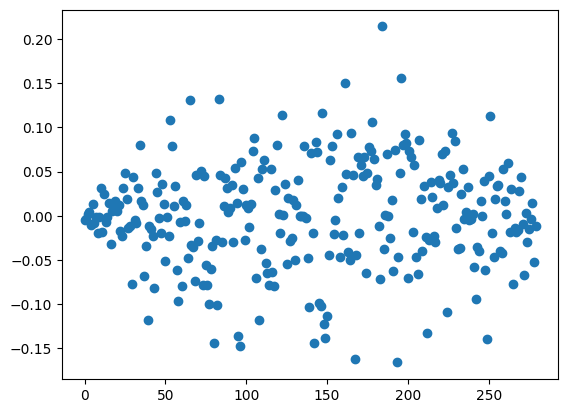

In [40]:
plt.scatter(torch.arange(len(evecs[-1])), evecs[-1])

In [41]:
class SpectralEmbeddingModel(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.C = C

        self.W = nn.Parameter(torch.randn(C, C))

        
    def forward(self, A):

        eigenvalues, eigenvectors = torch.linalg.eigh(A)
        sorted_indices = torch.argsort(torch.abs(eigenvalues), descending=True)
        V_C = eigenvectors[:, sorted_indices[:self.C]]

        return torch.softmax(V_C @ self.W, dim=1)

In [42]:
model = SpectralEmbeddingModel(C=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    pred = model(A)
    loss = criterion(Y, pred)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.4f}')

with torch.no_grad():
    final_pred = model(A)
    accuracy = calculate_accuracy(Y, final_pred)
    print(f'\nFinal accuracy: {accuracy:.4f}')


Epoch 0, Loss: 0.8132
Epoch 100, Loss: 0.8129
Epoch 200, Loss: 0.8126
Epoch 300, Loss: 0.8124
Epoch 400, Loss: 0.8122
Epoch 500, Loss: 0.8121
Epoch 600, Loss: 0.8120
Epoch 700, Loss: 0.8120
Epoch 800, Loss: 0.8120
Epoch 900, Loss: 0.8120

Final accuracy: 0.5143
